In [2]:
#inference code

import torch
import numpy as np
import os
import json
import joblib
from torch.utils.data import Dataset,DataLoader
from itertools import repeat
import pandas as pd
import math
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from pathlib import Path
data_dir =Path('/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/')
image_dir = Path('/common/users/vk405/EnergyLab/Data')
proc_data_dir = Path('/common/users/vk405/EnergyLab/Data/ProcData')
df = pd.read_csv(f'{data_dir}/tgtimgs.csv')



/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Dset(Dataset):
    def __init__(self,split= 'train',data_dir='/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/',
    image_dir='/common/users/vk405/EnergyLab/Data/ProcData'):
        self.split = split

        #hardcoded dir locs 
        self.data_dir = Path(data_dir)
        self.image_dir = Path(image_dir) 
        
        base_df = pd.read_csv(f'{self.data_dir}/tgtimgs.csv')
        base_df.loc[base_df.index[base_df['Target']>=1250.0],'Target'] = 1250.0
        
        trn_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
        self.scalar = MinMaxScaler().fit(trn_df['Target'].values.reshape(-1,1))
        #splits are hardcoded as per the original paper
        if self.split == 'train':
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
            
        elif self.split == 'valid':
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year == 2015])
            
        else:
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year > 2015])
        #set an upper-threshold.
        self.df.loc[self.df.index[self.df['Target']>=1250.0],'Target'] = 1250.0
        #self.df[self.df['Target']>=1300.0]['Target'] = 1300.0
        rescaled = self.scalar.transform(self.df['Target'].values.reshape(-1,1))
        self.df['Target'] = np.squeeze(rescaled)
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self,ind):
        try:
            imgs = sorted(eval(self.df.iloc[ind]['Imgs']),key = lambda x: int(x.split('/')[-1].split('.')[0]))
            target = self.df.iloc[ind]['Target']
            #image_dir = Path('/common/users/vk405/EnergyLab/Data/ProcData') 
            proc_imgs = [self.image_dir/(x.split('/')[-1].split('.')[0]+'.joblib') for x in imgs]
            proc_arrays = [joblib.load(ele) for ele in proc_imgs]
        except:
            print(ind)
            
        return (np.concatenate(proc_arrays,-1).reshape(-1,256,256))/255.0,target




    

In [3]:
def SCNN(n_ch=6):
    
    model = []
    model.append(nn.Conv2d(in_channels=n_ch, out_channels=64, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))
    
    model.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))

    model.append(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))

    model.append(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    #model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    #model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))

    model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    #model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    #model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))

    model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))




    return nn.Sequential(*model)




class VggModel(pl.LightningModule):
    def __init__(self,hparams,dset=None):
        super().__init__()
        self.save_hyperparameters()

        
        if hparams.framecnt != 2:
            raise NotImplementedError

        #get the complete model
        base_model = [SCNN(hparams.framecnt*3)]
        base_model.extend([nn.Flatten(),nn.Dropout(hparams.dropoutp),nn.Linear(8192,256),nn.Dropout(hparams.dropoutp),nn.Linear(256,1)])
        self.net = nn.Sequential(*base_model)

    def forward(self,x):
        #keep this for inference
        out = self.net(x)
        return out

    
    def training_step(self,batch,batch_idx):
        #for training
        x,y = batch
        y_hat = torch.squeeze(self.net(x.float()))

        loss = F.l1_loss(y_hat,y.float())
        self.log("train_loss",loss,on_step=True)
        return loss

    
    def validation_step(self,batch,batch_idx):
        #for training
        x,y = batch
        y_hat = torch.squeeze(self.net(x.float()))

        loss = F.l1_loss(y_hat,y.float())
        self.log("val_loss",loss,on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        lr = self.hparams.lr if 'lr' in self.hparams else 1e-5
        #lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False
        optimizer = torch.optim.Adam(self.parameters(), lr=lr,betas=(0.9,0.999),amsgrad=False)
        return optimizer




    

In [4]:
from argparse import Namespace
cfg = Namespace(
    version = 'trail',
    artifacts_loc = "/common/home/vk405/Projects/EnergyLab/Solar-forcast/artifacts/",
    data_dir = "/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/",
    image_dir = "/common/users/vk405/EnergyLab/Data/ProcData/",
    mode = 'train',
    loggers = ["csv"],
    seed = 0,
    cbs = ["checkpoint"],
    trainer = {'log_every_n_steps': 50,
    'max_epochs': 30},
    checkpoint = {"save_top_k": 5,
    "monitor": "val_loss","mode":"min"},
    dropoutp=0.2,
    framecnt=2,
    lr = 1.5e-5,
    batch_size=64
)

In [5]:
test_dset = Dset(split= 'test')

0.0875029172506183

<AxesSubplot:xlabel='MST'>

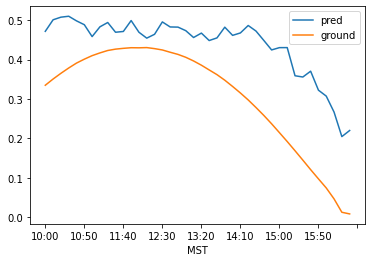

In [6]:
net = VggModel(cfg)

In [7]:
#trained model
weight_loc = '/common/home/vk405/Projects/EnergyLab/Solar-forcast/artifacts/ckpts/trail/epoch=27-val_loss=0.08.ckpt'
trnd_net = net.load_from_checkpoint(weight_loc)

In [8]:
test_loader = DataLoader(test_dset,\
            batch_size=64,shuffle=False,num_workers=4,pin_memory=True)

In [12]:
sampl_batch,sampl_labels = None,None
for x,y in test_loader:
    sampl_batch,sampl_labels = x,y
    break



In [15]:
preds = trnd_net(x.float())

In [20]:
y.shape

torch.Size([64])

In [9]:
def infer(model,loader):
    preds_lis = []
    truelabels = []
    with torch.no_grad():
        for x,y in tqdm(test_loader):
            preds = model(x.float())
            preds_lis.append(preds.squeeze().cpu().numpy())
            truelabels.append(y.cpu().numpy())
    return np.concatenate(preds_lis,axis=0),np.concatenate(truelabels,axis=0)
    


In [10]:
p,g = infer(trnd_net,test_loader)

  0%|          | 0/436 [00:13<?, ?it/s]


RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/common/home/vk405/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 34, in _pin_memory_loop
    data = pin_memory(data)
  File "/common/home/vk405/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 58, in pin_memory
    return [pin_memory(sample) for sample in data]
  File "/common/home/vk405/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 58, in <listcomp>
    return [pin_memory(sample) for sample in data]
  File "/common/home/vk405/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 50, in pin_memory
    return data.pin_memory()
RuntimeError: cuda runtime error (2) : out of memory at ../aten/src/THC/THCCachingHostAllocator.cpp:280


<AxesSubplot:xlabel='MST'>

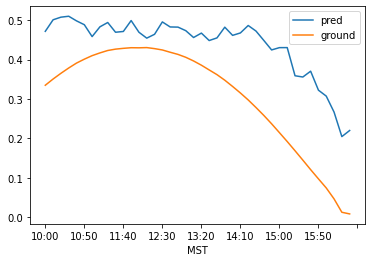

In [3]:
tst_preds = pd.read_csv(data_dir/'infered_vals.csv')

sampled_day = '2016-01-01'
tst_preds[tst_preds['Date'] ==sampled_day ].plot(x='MST',y=['pred','ground'])

In [4]:
np.mean(np.abs(tst_preds['pred']-tst_preds['ground']))

0.0875029172506183

In [21]:
base_df = pd.read_csv(f'{data_dir}/tgtimgs.csv')
trn_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
scalar = MinMaxScaler().fit(trn_df['Target'].values.reshape(-1,1))

In [28]:
pred_irradiance = scalar.inverse_transform(np.array(tst_preds[tst_preds['Date'] ==sampled_day]['pred']).reshape(-1,1))
true_irradiance = scalar.inverse_transform(np.array(tst_preds[tst_preds['Date'] ==sampled_day]['ground']).reshape(-1,1))

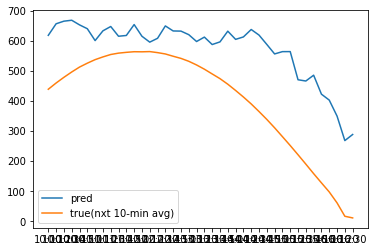

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(tst_preds[tst_preds['Date'] ==sampled_day ]['MST'],np.squeeze(pred_irradiance),label='pred')

plt.plot(tst_preds[tst_preds['Date'] ==sampled_day ]['MST'],np.squeeze(true_irradiance),label='true(nxt 10-min avg)')

plt.legend()

In [37]:
scalar.inverse_transform([[np.mean(np.abs(tst_preds['pred']-tst_preds['ground']))]])

array([[114.63905944]])

<AxesSubplot:ylabel='Frequency'>

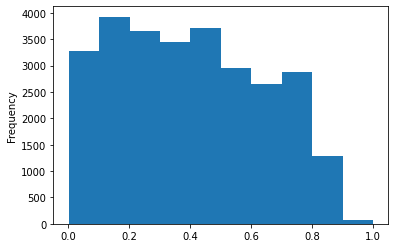

In [39]:
tst_preds['Target'].plot.hist()

In [47]:
#tst_preds['abs_error'] = np.abs(tst_preds['ground']-tst_preds['pred'])
tst_preds['error'] = tst_preds['pred']-tst_preds['ground']
tst_preds['error'].mean()

0.04148327552023407

In [48]:

small,med = tst_preds['Target'].quantile(0.33),tst_preds['Target'].quantile(0.66)

cloudy = tst_preds[tst_preds['Target']<=small]
normal = tst_preds[(tst_preds['Target']>small) & (tst_preds['Target']<=med)]
sunny = tst_preds[(tst_preds['Target']>med)]

In [51]:
# yes cloudy is bad(can do hypothesis testing for better confirmation.)
cloudy['error'].abs().mean(),sunny['error'].abs().mean()

(0.12742802076543575, 0.06025311855898195)

In [52]:
cloudy['error'].abs().mean(),normal['error'].abs().mean()

(0.12742802076543575, 0.0756505470010446)

hi
